# Data Preprocessing

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow as tf

In [4]:
dataset_path = "Augmented Dataset"

categories = ["Black Spot", "Downy Mildew", "Fresh Leaf"]

IMG_SIZE = (256, 256)

X = [] 
y = []
image_sizes = [] 


In [5]:
def preprocess_image(img_path, target_size=(256, 256)):
    """Load an image, resize it, and normalize pixel values."""
    img = Image.open(img_path).convert("RGB")
    original_size = img.size
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array, original_size


In [6]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    class_index = categories.index(category)

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)

        img_array, original_size = preprocess_image(img_path, IMG_SIZE)

        X.append(img_array)
        y.append(class_index)
        image_sizes.append(original_size)


In [7]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)  

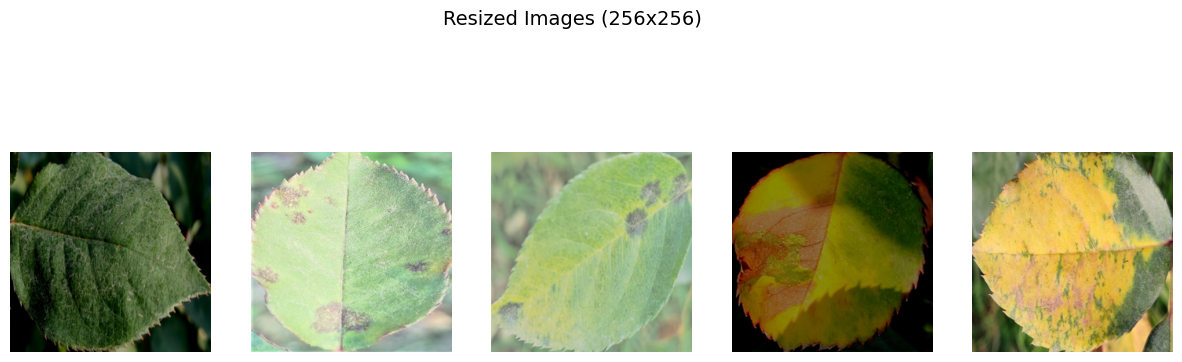

In [8]:

# demonstration of resized images from the dataset
num_samples = 5
indices = np.random.choice(len(X), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(indices):
    img = X[idx]  
    axes[i].imshow(img)
    axes[i].axis("off")

plt.suptitle("Resized Images (256x256)", fontsize=14)
plt.show()


# Histogram Visualization of Image Sizes

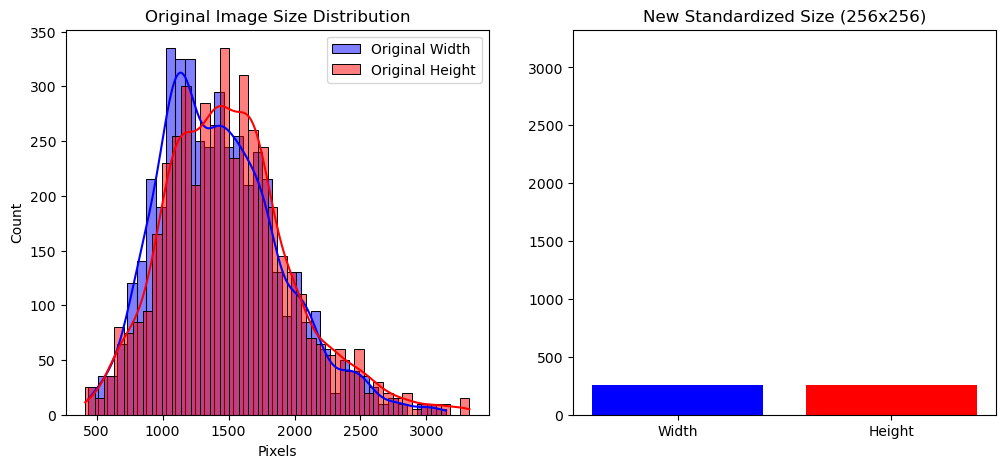

In [9]:
orig_widths, orig_heights = zip(*image_sizes)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(orig_widths, color="blue", label="Original Width", kde=True)
sns.histplot(orig_heights, color="red", label="Original Height", kde=True)
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.title("Original Image Size Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(["Width", "Height"], [IMG_SIZE[0], IMG_SIZE[1]], color=["blue", "red"])
plt.ylim(0, max(orig_widths + orig_heights))
plt.title("New Standardized Size (256x256)")

plt.show()

## CNN network

In [ ]:
# For y:
# 0 -> spot
# 1 -> mildew
# 2 -> fresh

X.shape

(4585, 256, 256, 3)

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

Epoch 1/10
92/92 [==============================] - 180s 2s/step - loss: 1.3215 - accuracy: 0.5174 - val_loss: 0.6697 - val_accuracy: 0.6281
Epoch 2/10
92/92 [==============================] - 188s 2s/step - loss: 0.7092 - accuracy: 0.6234 - val_loss: 0.6665 - val_accuracy: 0.6349
Epoch 3/10
92/92 [==============================] - 182s 2s/step - loss: 0.7032 - accuracy: 0.6268 - val_loss: 0.6327 - val_accuracy: 0.5531
Epoch 4/10
92/92 [==============================] - 171s 2s/step - loss: 0.6751 - accuracy: 0.6462 - val_loss: 0.6118 - val_accuracy: 0.6744
Epoch 5/10
92/92 [==============================] - 173s 2s/step - loss: 0.6500 - accuracy: 0.6544 - val_loss: 0.5700 - val_accuracy: 0.6785
Epoch 6/10
92/92 [==============================] - 172s 2s/step - loss: 0.6220 - accuracy: 0.6881 - val_loss: 0.5578 - val_accuracy: 0.7602
Epoch 7/10
92/92 [==============================] - 172s 2s/step - loss: 0.5925 - accuracy: 0.6956 - val_loss: 0.6198 - val_accuracy: 0.6812
Epoch 8/10
92

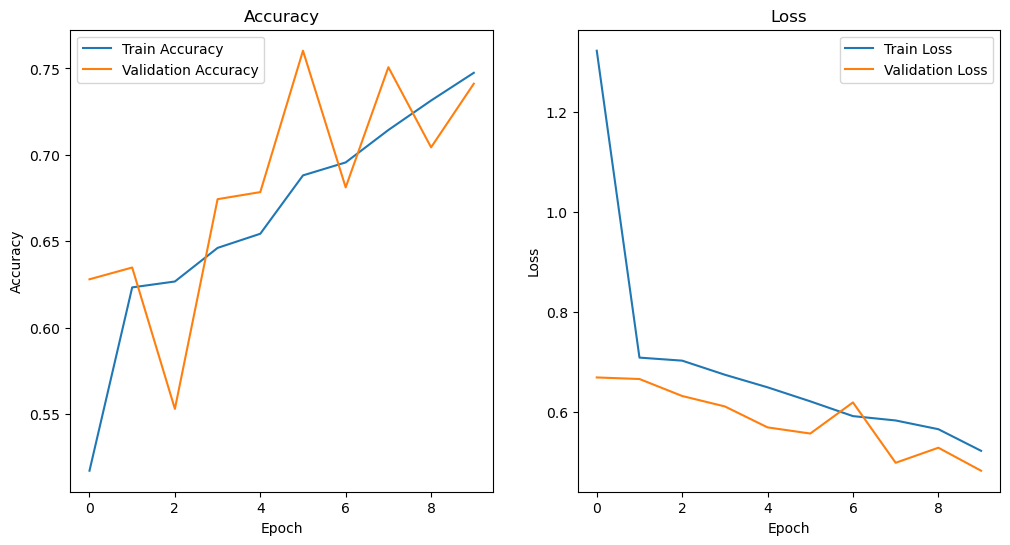

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Build CNN model
model = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),  # Input layer (224x224 images, 3 channels for RGB)

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the 3D feature maps to 1D for the fully connected layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(len(y), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse because labels are integers
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

29/29 [==============================] - 9s 312ms/step


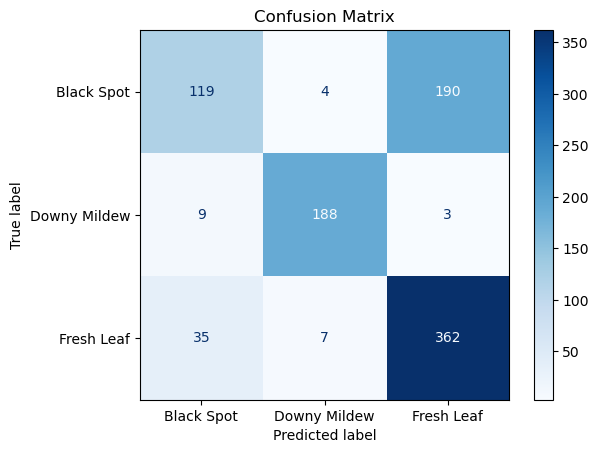

In [24]:
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()